In [16]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

SARSA implementation

Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q-table:
[[-1.75714946e-02 -8.29803627e-03 -2.79378207e-02 -1.16903822e-02]
 [-6.43734039e-01 -1.02945351e-01 -1.67657572e-01 -1.49424337e-02]
 [-2.71000000e+00 -8.10409255e-03  0.00000000e+00 -5.04346493e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.98918503e-03 -3.34263490e-02 -4.69560659e-01 -1.11794371e-01]
 [-8.01900000e-02 -1.05862458e-01 -6.29359702e+00 -2.08193559e-02]
 [-2.71000000e+00 -1.04071736e-03  0.00000000e+00 -8.10000097e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0

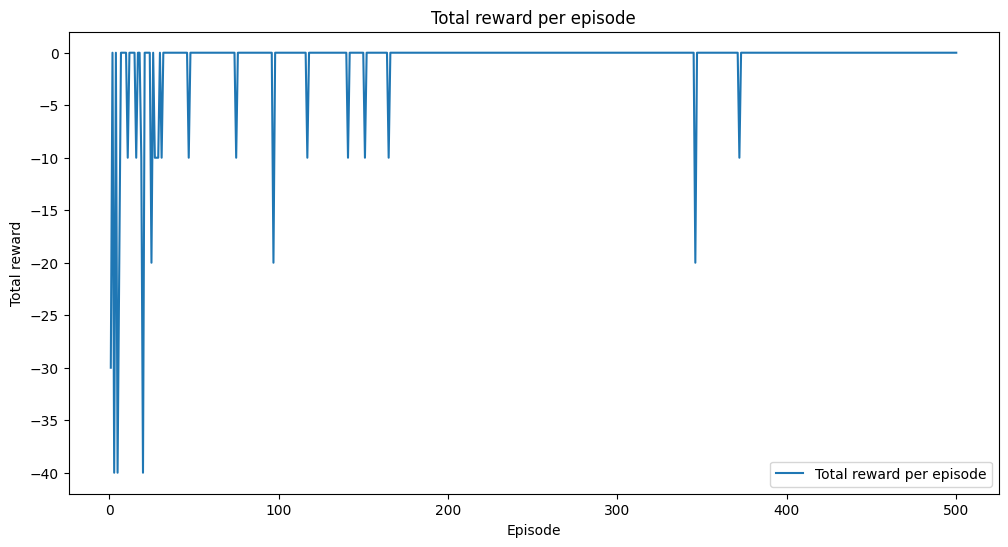

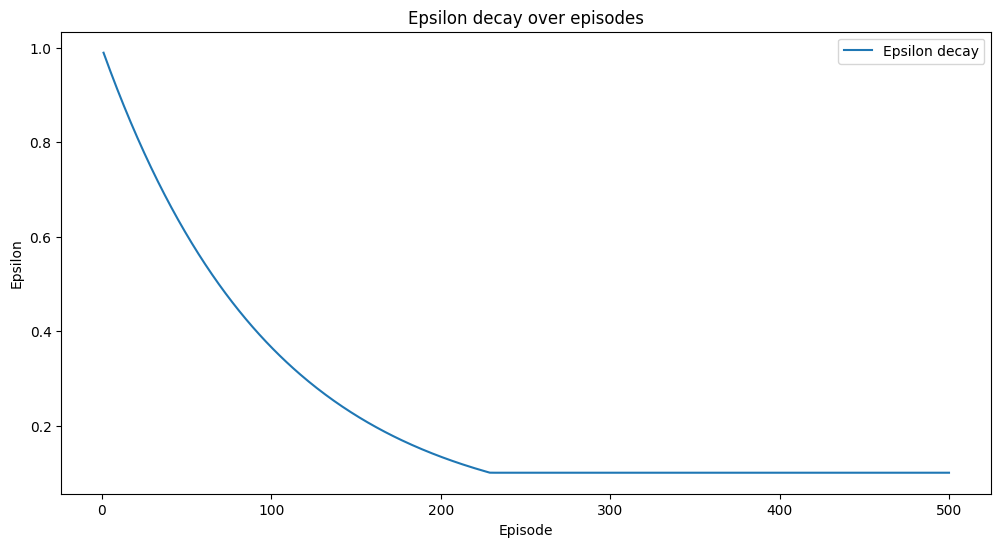

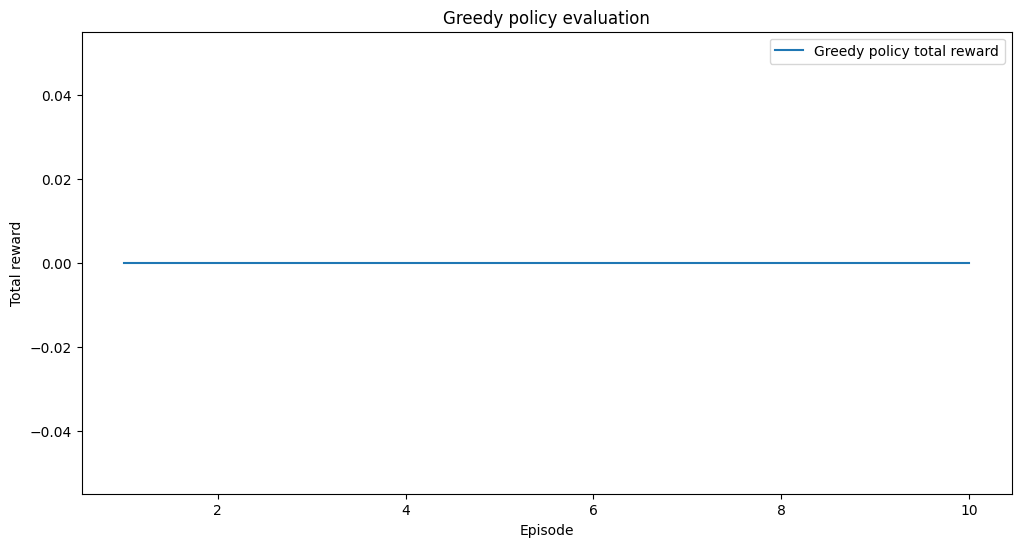

In [17]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()

        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0

        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = spaces.Discrete(4)

        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20
        self.rewards[1, 2] = -10
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10

        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  
            self.firefighter_position[0] += 1
        elif action == 1:  
            self.firefighter_position[0] -= 1
        elif action == 2:  
            self.firefighter_position[1] += 1
        elif action == 3:  
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1  #firefighter
        grid[self.rewards == 20] = 2  #rescue target
        grid[self.rewards == -10] = 3  #burning rooms

        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]

#SARSA implementation
def sarsa(env, episodes=500, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()  
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)  #choose A from S using policy defrived from Q[e.g. Epsilon greedy]
        total_reward = 0

        while True:
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)  #choose A' from S' using policy derived from Q [e.g. Epsilon greedy]

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])  #SARSA update rule
            total_reward += reward
            state, action = next_state, next_action # S <- S' ; A <- A'

            if terminated:
                break  #until S is terminated

        total_rewards.append(total_reward)  #storing the total rewards in the array for GRAPH
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)  #storing the epsilonm values for GRAPH

    return Q, total_rewards, epsilon_values  #returning the values

def epsilon_greedy(Q, state, epsilon, action_space_size):  #epsilon greedy policy
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])

def evaluate_greedy_policy(env, Q, episodes=10): #greedy policy evaluation
    total_rewards = []

    for _ in range(episodes):
        state, _ =env.reset()
        total_reward = 0

        while True:
            action = np.argmax(Q[state])
            next_state, reward, terminated, _, _ =env.step(action)
            total_reward +=reward
            state = next_state
            if terminated:
                break

        total_rewards.append(total_reward)

    return total_rewards

def plot_results(total_rewards, epsilon_values, greedy_rewards):  #plot results
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(greedy_rewards) + 1), greedy_rewards, label="Greedy policy total reward")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Greedy policy evaluation")
    plt.legend()
    plt.show()

env = FireFightersOperation()
initial_Q = np.zeros((env.observation_space.n, env.action_space.n))
print("Initial Q-table:")
print(initial_Q)
trained_Q, total_rewards, epsilon_values = sarsa(env)
print("Trained Q-table:")
print(trained_Q)
greedy_rewards = evaluate_greedy_policy(env, trained_Q)
plot_results(total_rewards, epsilon_values, greedy_rewards)


Hyperparameter tuning

Gamma:0.8, Epsilon Decay:0.9, Average Rewards:0.0
Gamma:0.8, Epsilon Decay:0.95, Average Rewards:0.0
Gamma:0.8, Epsilon Decay:0.99, Average Rewards:-0.2
Gamma:0.9, Epsilon Decay:0.9, Average Rewards:-0.4
Gamma:0.9, Epsilon Decay:0.95, Average Rewards:-0.2
Gamma:0.9, Epsilon Decay:0.99, Average Rewards:0.0
Gamma:0.95, Epsilon Decay:0.9, Average Rewards:0.0
Gamma:0.95, Epsilon Decay:0.95, Average Rewards:0.0
Gamma:0.95, Epsilon Decay:0.99, Average Rewards:16.4
Best Parameters:
{'gamma': 0.95, 'epsilon_decay': 0.99}


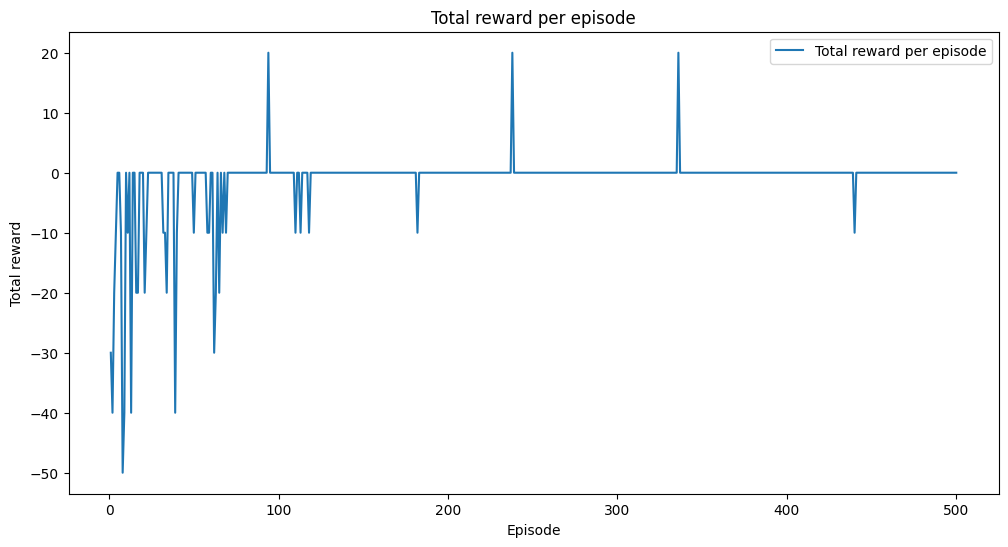

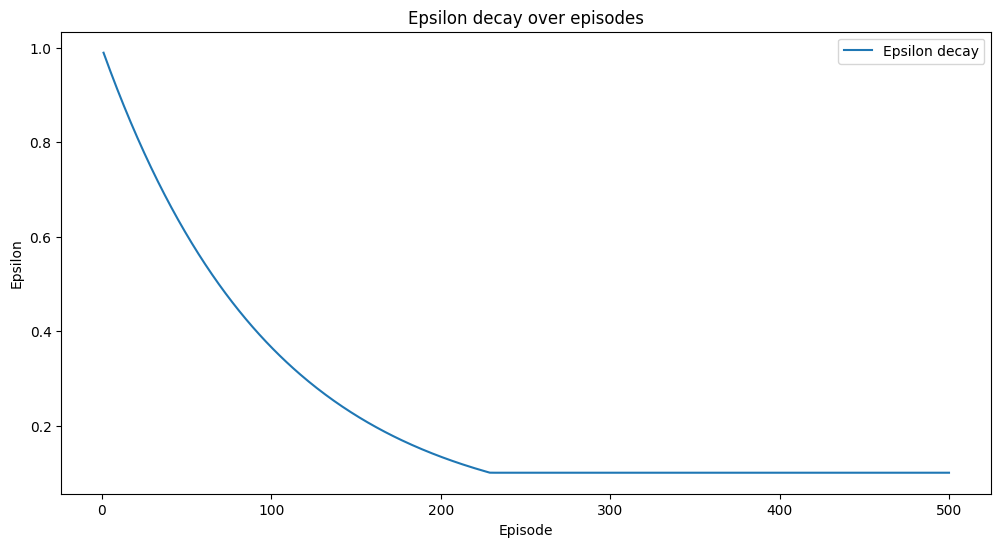

In [18]:
class FireFightersOperation(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(FireFightersOperation, self).__init__()
        self.grid_size = 5
        self.max_timesteps = 10
        self.timestep = 0
        self.observation_space = gym.spaces.Discrete(self.grid_size * self.grid_size)
        self.action_space = gym.spaces.Discrete(4)
        self.rewards = np.zeros((self.grid_size, self.grid_size))
        self.rewards[4, 4] = 20
        self.rewards[1, 2] = -10
        self.rewards[2, 2] = -10
        self.rewards[3, 2] = -10
        self.firefighter_position = [0, 0]

    def reset(self):
        self.timestep = 0
        self.firefighter_position = [0, 0]
        state = self._get_state()
        return state, {}

    def step(self, action):
        if action == 0:  # Down
            self.firefighter_position[0] += 1
        elif action == 1:  # Up
            self.firefighter_position[0] -= 1
        elif action == 2:  # Right
            self.firefighter_position[1] += 1
        elif action == 3:  # Left
            self.firefighter_position[1] -= 1

        self.firefighter_position = np.clip(self.firefighter_position, 0, self.grid_size - 1)
        reward = self.rewards[tuple(self.firefighter_position)]
        self.timestep += 1
        terminated = self.timestep >= self.max_timesteps or reward == 20
        truncated = False
        state = self._get_state()
        return state, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.full((self.grid_size, self.grid_size), 0, dtype=int)
        grid[tuple(self.firefighter_position)] = 1  
        grid[self.rewards == 20] = 2  
        grid[self.rewards == -10] = 3 
        print(grid)

    def _get_state(self):
        return self.firefighter_position[0] * self.grid_size + self.firefighter_position[1]


def sarsa(env, episodes=500, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_rewards = []
    epsilon_values = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon, env.action_space.n)
        total_reward = 0

        while True:
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space.n)

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            total_reward += reward
            state, action = next_state, next_action

            if terminated:
                break

        total_rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return Q, total_rewards, epsilon_values


def epsilon_greedy(Q, state, epsilon, action_space_size):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_size)
    else:
        return np.argmax(Q[state])


def plot_results(total_rewards, epsilon_values):
    episodes = np.arange(1, len(total_rewards) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, total_rewards, label="Total reward per episode")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Total reward per episode")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, epsilon_values, label="Epsilon decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay over episodes")
    plt.legend()
    plt.show()

env = FireFightersOperation()

gamma_values = [0.8, 0.9, 0.95]  #choosing hyperparameters
epsilon_decay_values = [0.90, 0.95, 0.99]

best_Q = None
best_rewards = -float('inf')
best_params = {}

for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        Q, total_rewards, epsilon_values = sarsa(env, gamma=gamma, epsilon_decay=epsilon_decay)
        average_rewards = np.mean(total_rewards[-50:])

        print(f"Gamma:{gamma}, Epsilon Decay:{epsilon_decay}, Average Rewards:{average_rewards}")

        if average_rewards > best_rewards:
            best_rewards = average_rewards
            best_Q = Q
            best_params = {'gamma':gamma, 'epsilon_decay':epsilon_decay}

print("Best Parameters:")
print(best_params)
final_Q, total_rewards, epsilon_values = sarsa(env, gamma=best_params['gamma'], epsilon_decay=best_params['epsilon_decay'])
plot_results(total_rewards, epsilon_values)